In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

import random
import json
import ast
import os
import cv2
import PIL

In [2]:
seed = 42
np.random.seed = seed

In [3]:
data_df = pd.read_csv(r"C:\Users\Anton\Downloads\TlkWaterMeters\data.tsv", sep='\t', header=0)

In [4]:
data_df['location'] = data_df['location'].apply(lambda x: ast.literal_eval(x)['data'])

In [6]:
images_data = []
dirname = r"C:\Users\Anton\Downloads\TlkWaterMeters\images"

for filename in data_df['photo_name']:
    img = cv2.imread(os.path.join(dirname, filename))
    img = cv2.resize(img, (128, 128))
    images_data.append(img)

images_data = np.array(images_data, dtype=np.uint8)

In [7]:
masks_data = []
dirname = r"C:\Users\Anton\Downloads\TlkWaterMeters\masks"

for filename in data_df['photo_name']:
    img = cv2.imread(os.path.join(dirname, filename))
    img = cv2.resize(img, (128, 128))
    img = img[:, :, 1]
    masks_data.append(img)

masks_data = np.array(masks_data, dtype=bool)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images_data, masks_data, test_size=0.2)

In [9]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

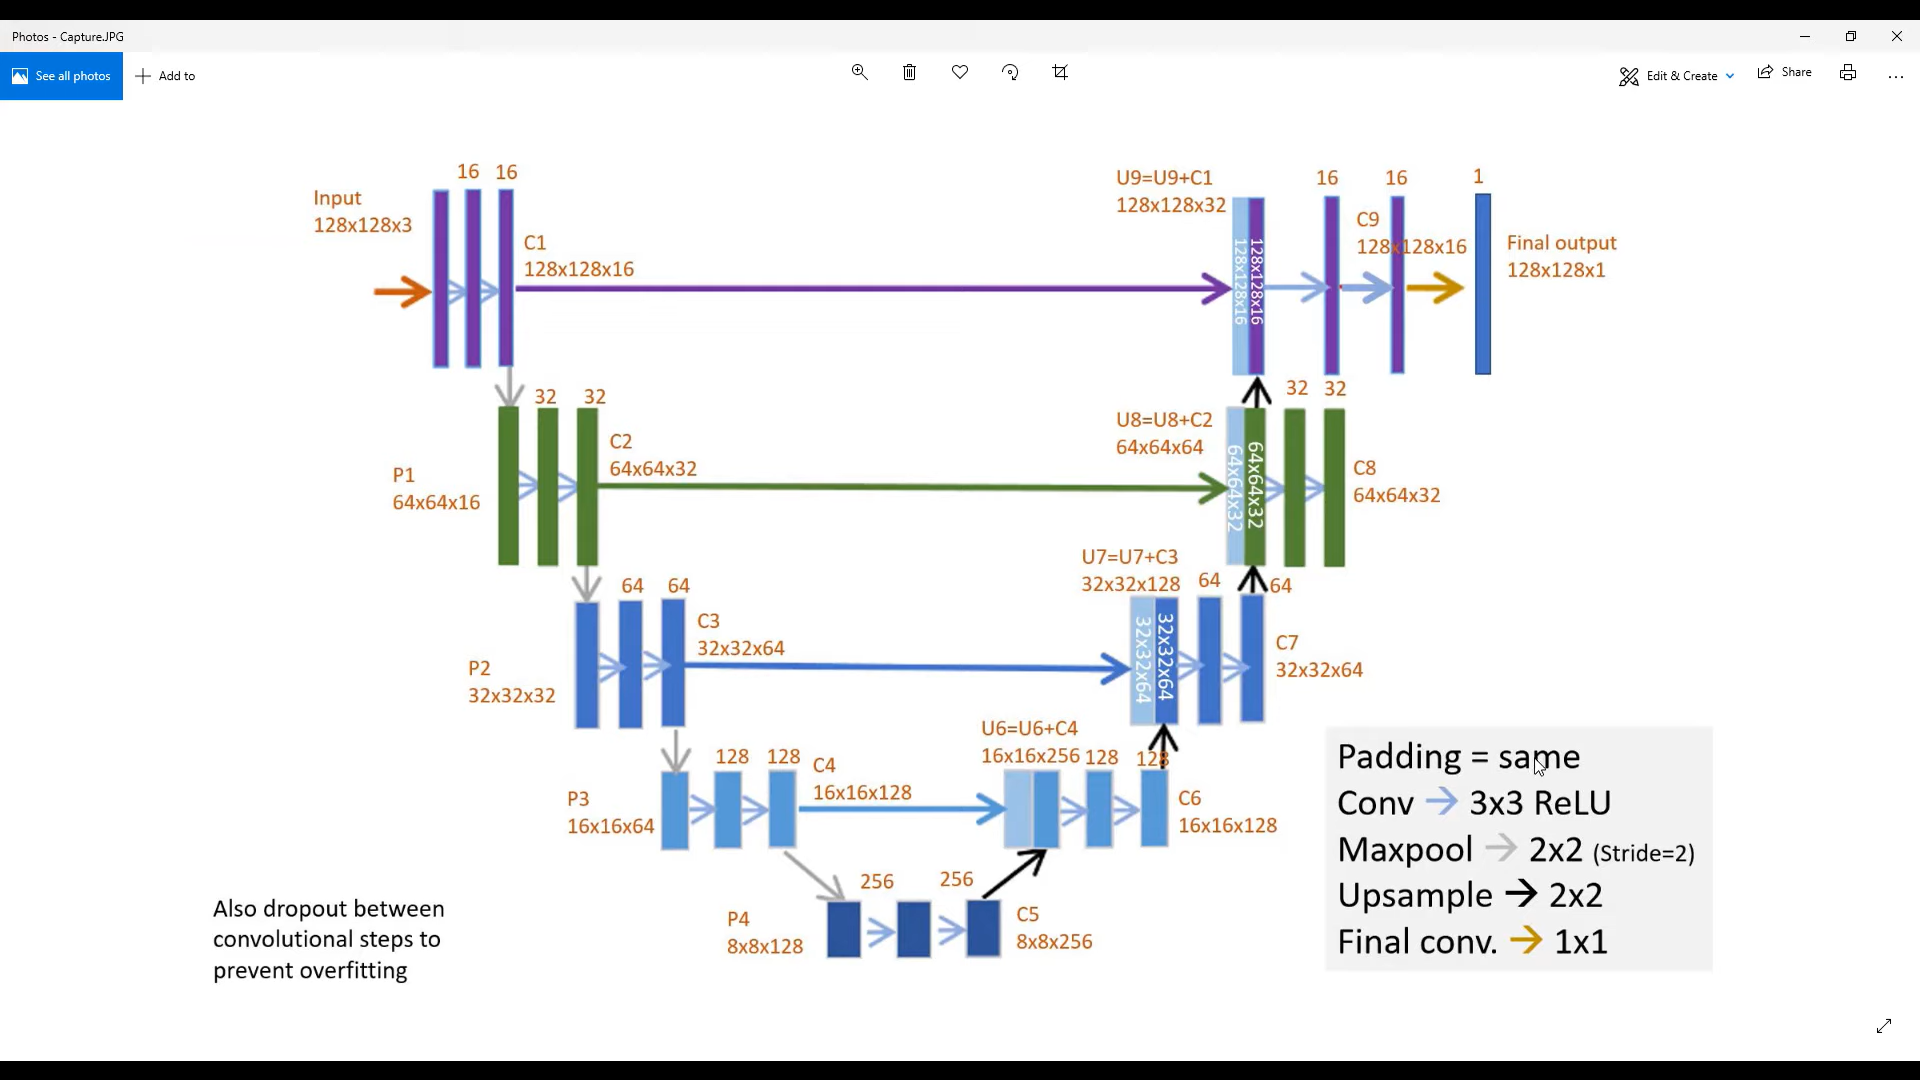

In [10]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [11]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [12]:
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [13]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [22]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                            

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

In [23]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('U-net Checkpoints/unet.h5', verbose=1, save_best_only=True)

In [24]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        checkpointer]

In [25]:
tf.config.run_functions_eagerly(True)

In [27]:
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
56/56 [==============================] - ETA: 0s - loss: 0.0830 - mean_io_u: 0.4881
Epoch 1: val_loss improved from inf to 0.08169, saving model to U-net Checkpoints\unet.h5
56/56 [==============================] - 114s 2s/step - loss: 0.0830 - mean_io_u: 0.4881 - val_loss: 0.0817 - val_mean_io_u: 0.4883
Epoch 2/25
56/56 [==============================] - ETA: 0s - loss: 0.0775 - mean_io_u: 0.4881
Epoch 2: val_loss improved from 0.08169 to 0.07627, saving model to U-net Checkpoints\unet.h5
56/56 [==============================] - 125s 2s/step - loss: 0.0775 - mean_io_u: 0.4881 - val_loss: 0.0763 - val_mean_io_u: 0.4883
Epoch 3/25
56/56 [==============================] - ETA: 0s - loss: 0.0708 - mean_io_u: 0.4881
Epoch 3: val_loss improved from 0.07627 to 0.06255, saving model to U-net Checkpoints\unet.h5
56/56 [==============================] - 118s 2s/step - loss: 0.0708 - mean_io_u: 0.4881 - val_loss: 0.0626 - val_mean_io_u: 0.4883
Epoch 4/25
56/56 [=======================

In [28]:
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

8/8 [==============================] - 6s 678ms/step


In [29]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

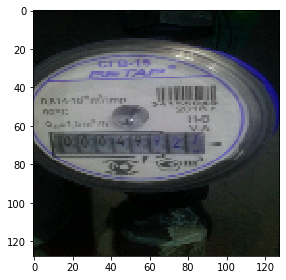

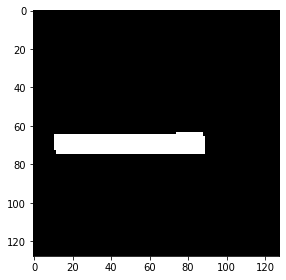

C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


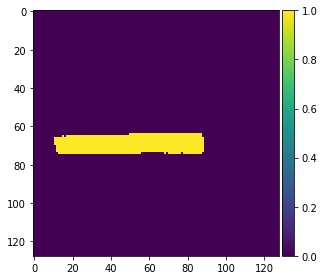

In [30]:
ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [31]:
miou = tf.keras.metrics.MeanIoU(num_classes=2)

In [32]:
miou.update_state(y_test, preds_test_t)
miou.result().numpy()

0.86184585

In [34]:
from scipy.optimize import minimize_scalar

In [39]:
def miou_max(threshold):
    miou = tf.keras.metrics.MeanIoU(num_classes=2)
    miou.update_state(y_test, (preds_test > threshold).astype(np.uint8))
    return - miou.result().numpy()

In [40]:
result = minimize_scalar(miou_max, bounds=(0, 1), method="Bounded")

In [41]:
result

     fun: -0.8645427
 message: 'Solution found.'
    nfev: 23
     nit: 23
  status: 0
 success: True
       x: 0.6083725597673628

In [43]:
preds_test_t = (preds_test > result.x).astype(np.uint8)
miou = tf.keras.metrics.MeanIoU(num_classes=2)
miou.update_state(y_test, preds_test_t)
miou.result().numpy()

0.8645427

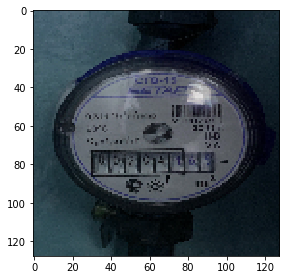

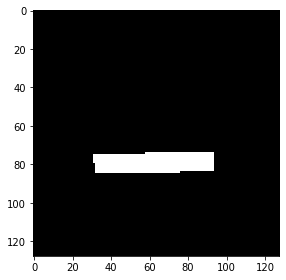

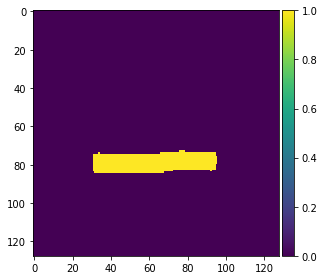

In [45]:
ix = random.randint(0, len(preds_test_t))
imshow(x_test[ix])
plt.show()
imshow(np.squeeze(y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

# Обрезаем изображения по маске (оригинальной)

In [96]:
def crop(img, bg, mask):
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    
    return cv2.bitwise_or(fg, fg_back_inv)

In [97]:
cropped_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\cropped_true"
images_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\images"
masks_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\masks"

In [98]:
for n, image, mask in zip(range(len(os.listdir(images_path))), os.listdir(images_path), os.listdir(masks_path)):
    dir_img = os.path.join(images_path, image)
    dir_mask = os.path.join(masks_path, mask)
    
    img = cv2.imread(dir_img).astype('uint8')
    mask = cv2.imread(dir_mask).astype('uint8')
    
    h, w, _ = img.shape
    
    mask = cv2.resize(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), (w, h))
    bg = np.zeros_like(img, 'uint8')

    new_image = crop(img,bg,mask)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

    where = np.array(np.where(new_image))
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    sub_image = new_image.astype('uint8')[x1:x2, y1:y2]

    cv2.imwrite(os.path.join(cropped_path, image), sub_image)